# **Resolution measurements on gold NPs**
---
#### Overview
* Load edge width data measured with FEI image
* Plot boxplots of edge width distributions

In [9]:
from pathlib import Path
import pandas as pd

### 1.1 Load edge width data measured with FEI Image
---

In [5]:
# Find directory
DATA_dir = Path("../data/4_Image_resolution-detectors/UHR")

# Select files and initialize DataFrame with image locations
df_ew = pd.DataFrame({'FilePos': list(DATA_dir.glob('*/*.csv'))})

# Build up DataFrame
df_ew['DetectionMode'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[0])
df_ew['Dwell'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[3].split('ns')[0])
df_ew['Pxsize'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[2].split('nm')[0])
df_ew['LE'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[1].split('keV')[0])

# Preview
df_ew.sort_values(['DetectionMode', 'LE'], inplace=True)
df_ew.sample(5)

,FilePos,DetectionMode,Dwell,Pxsize,LE
30,..\data\4_Image_resolution-detectors\UHR\SE_4k...,SE,10000,0.5,4
2,..\data\4_Image_resolution-detectors\UHR\ADF-S...,ADF-STEM,3000,0.2,25
9,..\data\4_Image_resolution-detectors\UHR\BSD_4...,BSD,10000,0.5,4
17,..\data\4_Image_resolution-detectors\UHR\OSTEM...,OSTEM,10000,0.5,4
4,..\data\4_Image_resolution-detectors\UHR\ADF-S...,ADF-STEM,3000,0.2,25


In [6]:
source2 = df_ew.groupby(by=['DetectionMode', 'LE','Dwell'])\
              .apply(lambda x: x.head(1))
source2

FilePos  \
DetectionMode LE  Dwell                                                         
ADF-STEM      25  3000  0   ..\data\4_Image_resolution-detectors\UHR\ADF-S...   
BSD           1.5 20000 6   ..\data\4_Image_resolution-detectors\UHR\BSD_1...   
              4   10000 9   ..\data\4_Image_resolution-detectors\UHR\BSD_4...   
OSTEM         4   10000 14  ..\data\4_Image_resolution-detectors\UHR\OSTEM...   
SE            1.5 10000 19  ..\data\4_Image_resolution-detectors\UHR\SE_1....   
              4   10000 26  ..\data\4_Image_resolution-detectors\UHR\SE_4k...   

                           DetectionMode  Dwell Pxsize   LE  
DetectionMode LE  Dwell                                      
ADF-STEM      25  3000  0       ADF-STEM   3000    0.2   25  
BSD           1.5 20000 6            BSD  20000    0.5  1.5  
              4   10000 9            BSD  10000    0.5    4  
OSTEM         4   10000 14         OSTEM  10000    0.5    4  
SE            1.5 10000 19            SE  10000    0.5  1.5  
              4   10000 26            SE  10000    0.5    4

### 1.2 Collect edge widths per detection condition
---

In [7]:
# Get histograms of edge widths
source2 = df_ew.copy()

# Initialize DataFrame to gather data per detection condition
df_ew_per_con = pd.DataFrame(columns=['DetectionMode', 'LE', 
                                     'Dwell', 'EdgeWidths'])

# Select subset of data files with same detection settings
for grp in tqdm(source2.groupby(by=['DetectionMode', 'LE','Dwell'])):
    
    # Select subset of data files with same detection settings
    for i, row in tqdm(grp[1].iterrows(), total=len(grp[1])):
        
        # Create empty array for edge widths
        ews = np.array([])
        
        # Read csv
        dist = np.loadtxt(row.FilePos, delimiter='  ')
        
        # Fill up np array with data
        data = np.zeros(int(np.sum(dist[:,1])))
        start = 0
        for value in dist:
            norv = int(value[1]) # number of repeated values
            data[start:(start+norv)] = value[0]
            start = start + norv # update
        data = data * 1e9 # nm
            
        # Populate DataFrame
        df_ew_per_con.loc[i, 'DetectionMode'] = row['DetectionMode']
        df_ew_per_con.loc[i, 'LE'] = row['LE']
        df_ew_per_con.loc[i, 'Dwell'] = row['Dwell']
        df_ew_per_con.loc[i, 'EdgeWidths'] = data.tolist()
df_ew_per_con.sample(3)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,DetectionMode,LE,Dwell,EdgeWidths
9,BSD,4,10000,"[1.4553488414392701, 1.4553488414392701, 1.455..."
30,SE,4,10000,"[1.66360281106392, 1.66360281106392, 1.6636028..."
7,BSD,1.5,20000,"[0.46751880145024, 0.46751880145024, 0.4675188..."


### 1.3 Plot distributions of edge width per detection condition
---

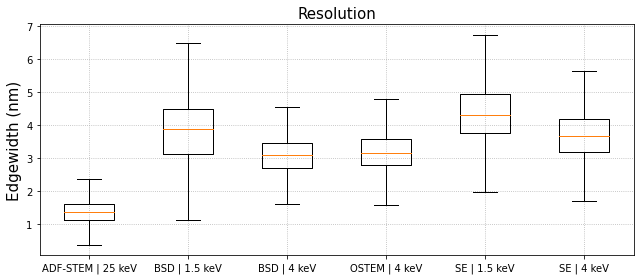

In [8]:
# Data
source4 = df_ew_per_con.copy()
fs = 15

# Make figure
fig, ax = plt.subplots(figsize=(9, 4))
ews = []
labels = []
legend = ['ADF-STEM','BSD','BSD','OSTEM','SE','SE']

# Plot results
for j, grp in enumerate(source4.groupby(by=['DetectionMode', 'LE', 'Dwell'])):
    
    # Aggregate particles per subset of images
    ew_subset = []
    
    # Select subset of images with same detection settings
    for i, row in grp[1].iterrows():
        ew_subset = ew_subset + row['EdgeWidths']
    ews.append(ew_subset)
    labels.append(f"{legend[j]} | {row['LE']} keV")

# Plot boxplot
ax.boxplot(ews, labels=labels, showfliers=False)   

# Axes aesthetics
ax.grid(which='both', ls=':') 
ax.set_title('Resolution', fontsize=fs)
ax.set_ylabel('Edgewidth (nm)', fontsize=fs)
plt.tight_layout()    
# plt.savefig('35%-65%-edgewith', dpi=150)